# Exploratory Data Analysis (EDA)

## Objective
The goal of this notebook is to understand the structure of the Home Credit Default Risk dataset, explore key drivers of loan default, and identify data quality issues that will inform feature engineering and modeling decisions.

This analysis focuses on:
- Target variable distribution and class imbalance
- Key applicant characteristics related to default risk
- Missing data patterns and potential signal in missingness
- Early insights that guide modeling choices

---

## Dataset Overview
Primary dataset:
- `application_train.csv`: Loan application data with default labels (`TARGET`)

Key target definition:
- `TARGET = 1`: Client defaulted on loan
- `TARGET = 0`: Client repaid loan

---

## Key Questions
1. What proportion of applicants default?
2. Which applicant features show clear separation between defaulters and non-defaulters?
3. How severe is class imbalance?
4. Which variables have high missingness, and is missingness informative?
5. Are there obvious data quality issues (outliers, impossible values)?

---

## EDA Plan
1. Load and inspect data
2. Examine target distribution
3. Analyze numeric features vs target
4. Analyze categorical features vs target
5. Investigate missing values
6. Summarize findings and modeling implications


## 1. Load and Inspect Data

In [4]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)

# Plot style
sns.set(style="whitegrid")


In [5]:
from pathlib import Path

# Project root assumed to be the VS Code workspace root
PROJECT_ROOT = Path.cwd().parents[0]

DATA_DIR = PROJECT_ROOT / "data"

df = pd.read_csv(DATA_DIR / "application_train.csv")

print("Shape:", df.shape)
df.head()


Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,-3648.000,-2120,NaN,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188,-1186.000,-291,NaN,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,NaN,0.096,0.053,0.985,0.796,0.060,0.080,0.035,0.292,0.333,0.013,0.077,0.055,0.004,0.010,0.092,0.054,0.985,0.804,0.050,0.081,0.035,0.292,0.333,0.013,0.079,0.055,0.000,0.000,0.097,0.053,0.985,0.799,0.061,0.080,0.035,0.292,0.333,0.013,0.079,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,135000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010,-19046,-225,-4260.000,-2531,26.000,1,1,1,1,1,0,Laborers,1.000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.556,0.730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
target_counts = df["TARGET"].value_counts()
target_rates = df["TARGET"].value_counts(normalize=True)

summary = pd.DataFrame({
    "count": target_counts,
    "percent": (target_rates * 100).round(2)
})

summary

,count,percent
TARGET,,
0,282686,91.930
1,24825,8.070


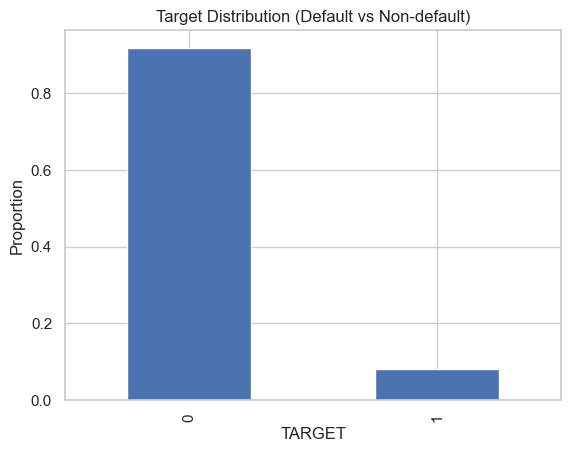

In [8]:
ax = target_rates.sort_index().plot(kind="bar")
ax.set_title("Target Distribution (Default vs Non-default)")
ax.set_xlabel("TARGET")
ax.set_ylabel("Proportion")
plt.show()

### EDA Takeaways: Target Variable
- The dataset contains approximately 307k loan applications with 122 features
- Default rate (`TARGET = 1`) is approximately 8%, indicating significant class imbalance
- This imbalance suggests that accuracy alone will be a misleading metric
- Precision, recall, and threshold selection will be important in downstream modeling

## 2. Missing Value Analysis

Understanding missing data patterns is critical, as missingness itself may carry predictive signal in credit risk modeling.

In [9]:
missing = (
    df.isnull()
      .mean()
      .sort_values(ascending=False)
      .to_frame(name="missing_pct")
)

missing.head(10)

,missing_pct
COMMONAREA_AVG,0.699
COMMONAREA_MODE,0.699
COMMONAREA_MEDI,0.699
NONLIVINGAPARTMENTS_MEDI,0.694
NONLIVINGAPARTMENTS_MODE,0.694
NONLIVINGAPARTMENTS_AVG,0.694
FONDKAPREMONT_MODE,0.684
LIVINGAPARTMENTS_AVG,0.684
LIVINGAPARTMENTS_MEDI,0.684
LIVINGAPARTMENTS_MODE,0.684


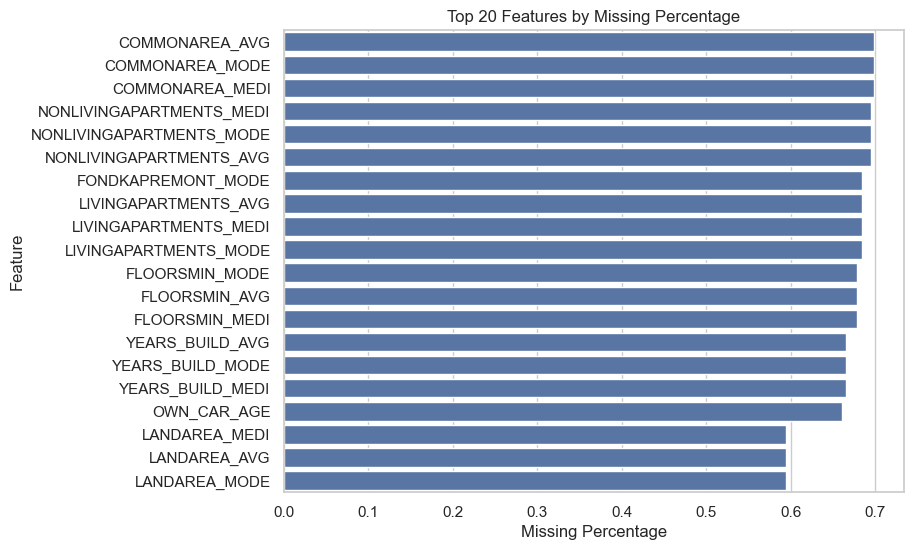

In [10]:
top_missing = missing.head(20)

plt.figure(figsize=(8, 6))
sns.barplot(
    x=top_missing["missing_pct"],
    y=top_missing.index,
    orient="h"
)
plt.title("Top 20 Features by Missing Percentage")
plt.xlabel("Missing Percentage")
plt.ylabel("Feature")
plt.show()

In [11]:
# Example: investigate missingness for a high-missing feature
feature = missing.index[0]

df[f"{feature}_missing"] = df[feature].isnull().astype(int)

df.groupby(f"{feature}_missing")["TARGET"].mean()

COMMONAREA_AVG_missing
0   0.069
1   0.086
Name: TARGET, dtype: float64

### EDA Takeaways: Missing Data
- Many features exhibit high levels of missingness, especially from external credit bureau sources
- Missingness may reflect limited credit history and could be predictive of default risk
- Missing indicators may be useful features in modeling
- Careful imputation or model selection will be required to handle missing values effectively

## 3. Numeric Feature Analysis

This section explores a small number of numeric applicant features to identify patterns associated with loan default and to guide feature engineering and model selection.

In [12]:
numeric_features = [
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "DAYS_BIRTH",
    "AMT_CREDIT",
    "AMT_INCOME_TOTAL"
]

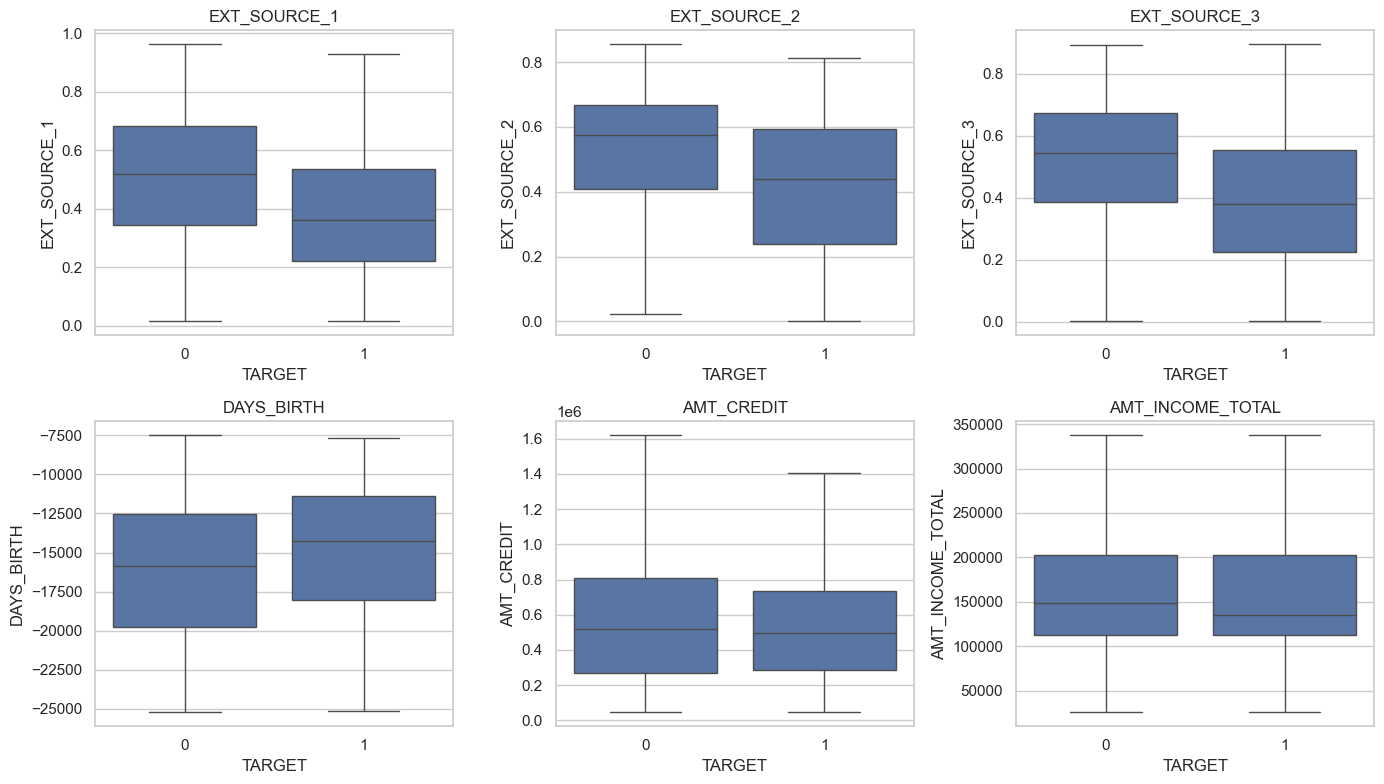

In [13]:
plt.figure(figsize=(14, 8))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(
        data=df,
        x="TARGET",
        y=feature,
        showfliers=False
    )
    plt.title(feature)

plt.tight_layout()
plt.show()

In [14]:
quantile_feature = "EXT_SOURCE_2"

df["ext2_bin"] = pd.qcut(df[quantile_feature], q=10, duplicates="drop")

default_rate_by_bin = (
    df.groupby("ext2_bin")["TARGET"]
      .mean()
      .reset_index()
)

default_rate_by_bin

C:\Users\jakey\AppData\Local\Temp\ipykernel_28872\1878536719.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("ext2_bin")["TARGET"]


,ext2_bin,TARGET
0,"(-0.0009999183, 0.216]",0.184
1,"(0.216, 0.34]",0.121
2,"(0.34, 0.44]",0.100
3,"(0.44, 0.512]",0.084
4,"(0.512, 0.566]",0.074
5,"(0.566, 0.608]",0.067
6,"(0.608, 0.646]",0.058
7,"(0.646, 0.682]",0.049
8,"(0.682, 0.722]",0.042
9,"(0.722, 0.855]",0.030


### EDA Takeaways: Numeric Features
- External risk scores (EXT_SOURCE_*) show strong separation between defaulters and non-defaulters
- Higher external risk scores are associated with significantly lower default rates
- Income and credit amounts show weaker direct separation and may require normalization or interaction features
- Binned default rate analysis suggests monotonic relationships suitable for logistic regression

In [15]:
df.drop(columns=["ext2_bin"], inplace=True)

## 4. Categorical Feature Analysis

This section explores a small set of categorical features to identify patterns associated with default risk and inform encoding strategies for modeling.

In [16]:
categorical_features = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY"
]

In [17]:
def default_rate_by_category(df, feature):
    return (
        df.groupby(feature)["TARGET"]
          .agg(
              count="size",
              default_rate="mean"
          )
          .sort_values("default_rate", ascending=False)
    )

for feature in categorical_features:
    print(f"\nDefault rates by {feature}")
    display(default_rate_by_category(df, feature))


Default rates by NAME_CONTRACT_TYPE


,count,default_rate
NAME_CONTRACT_TYPE,,
Cash loans,278232,0.083
Revolving loans,29279,0.055



Default rates by CODE_GENDER


,count,default_rate
CODE_GENDER,,
M,105059,0.101
F,202448,0.070
XNA,4,0.000



Default rates by FLAG_OWN_CAR


,count,default_rate
FLAG_OWN_CAR,,
N,202924,0.085
Y,104587,0.072



Default rates by FLAG_OWN_REALTY


,count,default_rate
FLAG_OWN_REALTY,,
N,94199,0.083
Y,213312,0.080


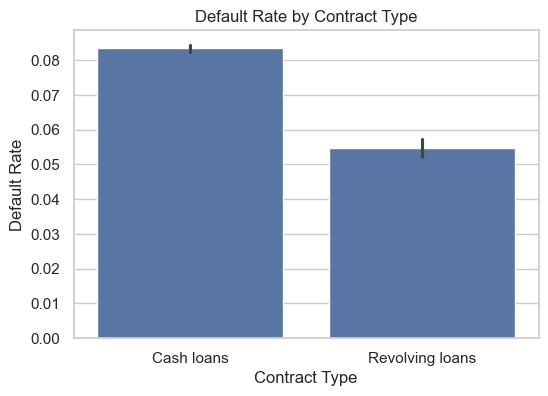

In [18]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df,
    x="NAME_CONTRACT_TYPE",
    y="TARGET"
)
plt.title("Default Rate by Contract Type")
plt.ylabel("Default Rate")
plt.xlabel("Contract Type")
plt.show()

### EDA Takeaways: Categorical Features
- Certain categorical variables show meaningful differences in default rates across groups
- Contract type exhibits clear separation, suggesting it should be retained in modeling
- Binary ownership indicators (car, real estate) show modest but consistent effects
- Low-cardinality categorical variables are suitable for one-hot encoding

## EDA Summary and Modeling Implications

Key findings from exploratory analysis:
- The target variable is highly imbalanced (~8% default rate), requiring careful metric selection and threshold optimization
- Missingness is prevalent and may itself be predictive of default risk
- External risk scores (EXT_SOURCE_*) show strong monotonic relationships with default probability
- Numeric features exhibit patterns suitable for both linear and tree-based models
- Select categorical features provide additional signal and can be encoded efficiently

Modeling implications:
- Accuracy alone will be insufficient; precision-recall tradeoffs must be evaluated
- Logistic regression will require imputation and missing indicators
- Tree-based models can naturally handle nonlinearities and missing values
- Cost-sensitive threshold selection will be critical for business-aligned decisions